In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from TurkishStemmer import TurkishStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Data exploration, first pass: more cleaning functions
This section creates a column with ads and whitespace removed (`fixed_text`) and a column with Turkish stopwords removed and words stemmed according to the `TurkishStemmer()` function (`processed_text`). These functions are added to the cleaning script. 

In [4]:
df = pd.read_csv('../assets/lyrics/lyrics_scraped_20180621-134937.csv', index_col = 0)

In [5]:
df.shape

(1326, 4)

In [6]:
df.head()

,artist,title,album,text
0,Sezen Aksu,1945,Git,1945 Gel asırlardan uzan da tut ellerimi sımsı...
1,Sezen Aksu,1980,1980,Sigaramın dumanına sarsam saklasam seni Gitme...
2,Sezen Aksu,Ablam Aşktan Öldü,şarkı söylemek lazım,Ablam aşktan öldü Herşey filmlerdeki gibi oldu...
3,Sezen Aksu,Acıtmışım Canını Sevdikçe,Öptüm,Hani yangın yerinde Sevmiştim ben seni Darmada...
4,Sezen Aksu,Ada Vapuru,Öptüm,ADA VARUPU YANDAN ÇARKLI BAYRAKLAR DONANMIŞ CA...


In [ ]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('turkish')]
    
    # stemming
    stemmer = TurkishStemmer()
    
    text_processed = [stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return " ".join(text_processed) ## <-- we're keeping our words distinct

In [ ]:
test_text = df['text'][34]

In [ ]:
text_process(test_text)

In [ ]:
df['processed_text'] = df['text'].map(text_process)

In [ ]:
df['processed_text']
df['num_words'] = [len(x) for x in df['text'].str.split(" ")]

In [ ]:
df.loc[1,['text', 'num_words']]['num_words']

In [ ]:
df.sort_values('num_words', ascending=False)

In [ ]:
test = df.loc[1246, 'text']

In [ ]:
test

In [ ]:
pattern = r'(eval.*])'

In [ ]:
test = re.sub(pattern, "", test)
test = re.sub(r"\s+", " ", test)
test

In [ ]:
def remove_ads(text):
    pattern = r'(eval.*])'
    return re.sub(pattern, "", text)

def regularize_whitespace(text):
    whitepattern = r'\s+'
    return re.sub(whitepattern, " ", text)

def remove_and_reg(text):
    text = remove_ads(text)
    text = regularize_whitespace(text)
    return text

In [ ]:
df['fixed_text'] = df['text'].map(remove_and_reg)

In [ ]:
df['fixed_text']

In [ ]:
df[df['title'].str.find('Dost') > 0]

In [ ]:
df.loc[1287, 'fixed_text'].strip()

In [ ]:
df.loc[1287, 'text']

In [ ]:
df[df['text'].str.contains(" les")]['text']

In [ ]:
df.loc[449, 'fixed_text'].strip()

In [ ]:
df.loc[449, 'text'].strip()

In [ ]:
df[(df['artist'] == 'Candan Erçetin') & df['album'].str.contains("Aranjman")]

In [ ]:
df.loc[1313,'text'].strip()

In [ ]:
df.loc[1313, 'title']

In [ ]:
for text in df.loc[1310:1320, 'fixed_text']:
    print(text)
    print('_-----_')

In [ ]:
re.sub(r'[^A-Za-z ]', "", df.loc[1313,'text'])

In [ ]:
set(df.loc[1313,'text'].strip().lower().split(" "))

# Playing with word2vec

In [ ]:
from gensim.models import word2vec

In [ ]:
f = "assets/lyrics/lyrics_scraped_20180621-134937.csv"
df = pd.read_csv(f, index_col=0)

In [ ]:
df.shape

In [ ]:
df['artist'].value_counts()

In [ ]:
num_features = 400    # Word vector dimensionality                      
min_word_count = 15   # Minimum word count (seems to mean that if a word appears less than this number ignore it)                        
num_workers = 4       # Number of threads to run in parallel
context = 4          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [ ]:
text = df['text'].map(remove_and_reg)

In [ ]:
text = [i.lower().split(" ") for i in text]

In [ ]:
model = word2vec.Word2Vec(text, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [ ]:
voc = list(model.wv.vocab.keys())

In [ ]:
voc

In [ ]:
model.wv.most_similar('çocuklar', topn=30)

# English testing

In [ ]:
df = pd.read_csv('assets/test.csv')

In [ ]:
df.columns = ['artist','title','album','text']

In [ ]:
def check_for_english(text):
    text_words = text.split(" ")
    english_words = set(['I', "we're", "the", "an", "one", "to", "give", "love"])
    counter = 0
    for word in text_words:
        if word in english_words:
            counter += 1
    return counter
    

In [ ]:
df['text'] = df['text'].map(remove_and_reg)

In [ ]:
df['english_score'] = df['text'].map(check_for_english)

In [ ]:
df[df['english_score'] == 0].shape

In [ ]:
df[df['english_score'] != 0].shape

In [ ]:
for i in df[df['english_score'] != 0]['text']:
    print(i)
    print("----------------")

In [ ]:
i = 0

In [ ]:
i += 30
df[df['english_score'] > 1]['text'][i:i+30]


In [ ]:
df.loc[89, 'title']

# Testing to marry spotify data to cleaned thing
## 1\. Imports and functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from TurkishStemmer import TurkishStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

def remove_ads(text):
    pattern = r'(eval.*])'
    return re.sub(pattern, "", text)

def regularize_whitespace(text):
    whitepattern = r'\s+'
    return re.sub(whitepattern, " ", text)

def remove_and_reg(text):
    text = remove_ads(text)
    text = regularize_whitespace(text)
    return text

def check_for_english(text):
    text_words = text.split(" ")
    english_words = set(['I', "we're", "the", "an", "one", "to", "give", "love"])
    counter = 0
    for word in text_words:
        if word in english_words:
            counter += 1
    return counter

## 2\. Reading in data
    - `spotify_df` is scraped from spotify, top hits, with a column for verification
    - `main_df` is scraped from alternatifim, with names, artists

In [ ]:
spotify_df = pd.read_csv('../assets/lyrics_with_spotify.csv', index_col=0)
main_df = pd.read_csv('../assets/lyrics/all_lyrics_scraped_20180625-155423.csv', index_col = 0)

3\. Cleaning functions to main data

In [ ]:
main_df['text'] = main_df['text'].map(remove_and_reg)
main_df['english_score'] = main_df['text'].map(check_for_english)
main_df = main_df[main_df['english_score'] == 0]

In [ ]:
main_df.head(2)

In [ ]:
spotify_df.head(2)

## 4\. Joining the data together. They share an index, and the columns `real_data` and `title` should be exactly the same.

In [ ]:
joined_df = pd.concat([main_df, spotify_df], axis=1)

## 5\. Getting rid of `NaN` rows and rows where the spotify name and real name aren't exactly the same
    In the spotify data, whenever a song couldn't be found, the script put a NaN into that slot. THe first step is to jsut remove that. In the future, if I decide to try other sources for year data, some of these slots could be filled. Until then I'm not going to worry about it.
    
    This might be overly conservative, and I might be missing data. My justification is that of course I'm missing 'data'. In the real world there are thousands of songs that aren't transcribed, thousands of dates that are unrecorded. I can try to do better, perhaps, but there is no such thing as "all the data" in this circumstance.

In [ ]:
joined_df_no_nas = joined_df.dropna()

In [ ]:
print(joined_df.shape)
print(joined_df_no_nas.shape)

In [ ]:
mask = joined_df_no_nas['title'] == joined_df_no_nas['name']

In [ ]:
mask.mean()

In [ ]:
joined_df_no_nas[mask].shape

In [ ]:
joined_df_no_nas[mask].to_csv('../assets/lyrics/master_data_20180626.csv')

In [ ]:
df = joined_df_no_nas[mask].copy()

In [ ]:
times = pd.to_datetime(df['release'])

In [ ]:
df.drop('real_name', axis = 1, inplace = True)

In [ ]:
df.columns = ['artist_name', 'song_title', 'album_name', 'song_text', 'english_score', 'release_date', 'song_name']

In [ ]:
df.drop('english_score', axis  =1, inplace=True)

In [ ]:
df.head()

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [ ]:
df['year'] = df['release_date'].dt.year

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

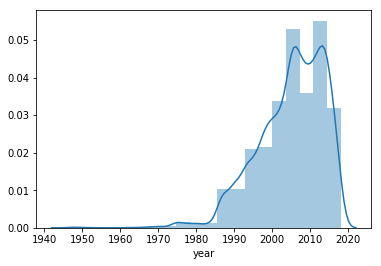

In [59]:
sns.distplot(df['year'], bins = 25)

In [61]:
df['year'].min()

1946

In [62]:
df[df['year'] == 1946]

,artist_name,song_title,album_name,song_text,release_date,song_name,year
26673,Hamiyet Yüceses,Kadifeden Kesesi,Her Yer Karanlık,Kadifeden kesesi Kahveden gelir sesi Oturmuş k...,1946-08-04,Kadifeden Kesesi,1946
